## 루브릭

### 1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다  
 - 중복, 결측치 확인
 - 불용어 처리
 - sos, eos 토큰 삽입
 - 정수 인코딩
 - 희소 단어 제거
 - 패딩
 
### 2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.

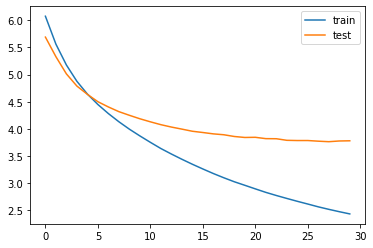

In [131]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

앞의 10개 기사를 보며 요약을 평가   
요약을 잘 한 경우도 있었지만, 맥락을 잘못 잡은 경우도 있었음

1. 잘 된 요약  

> 실제 요약 : indian man wins lottery crore abu dhabi   
  예측 요약 :  indian man wins lottery lottery auction  
  lottery의 중복처럼 단어가 중복되는 경우가 종종 있었음  
  (다른 예시 : 예측 요약 :  uk court bans use illegal illegal)

> 원문 : actress malaika arora asked reports suggesting dating arjun kapoor responded asking need gossip everybody laughing happy talking us talk event think interesting right added earlier malaika denied dating rumours said arjun good friend   
실제 요약 : need gossip malaika link arjun   
예측 요약 :  media malaika denies rumours dating rumours  
실제 요약과 조금 다르지만, 원문을 보면 상당히 요약을 잘하였음

2. 일부 단어 일치, 조금 요약의 유사성 존재

> 실제 요약 : named `scam`  
 예측 요약 :  cbi seizes crore worth crore `scam`  

> 실제 요약 : `uk` taken europe highest `court` air pollution   
예측 요약 :  `uk` `court` bans use illegal illegal  

3. 완전히 잘못된 요약  

> 실제 요약 : century longest lunar eclipse july visible india   
예측 요약 :  india witness first ever years


### 3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.

추상적 요약을 하던 기사자료를 추출적 요약의 방식으로 처리할 수는 없었다.  
기사의 내용이 너무 적은 것으로 파악되며, LMS상에서 제공한 데이터의 요약으로 비교를 하였다.   

아래가 추출적 요약을 한 결과물이다.  
`'Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.'`  
훨씬 문법적으로 깔끔하고, 중복단어가 나오지도 않았다.  
원문 전체를 읽지는 않아서 요약이 잘 되었는지는 모르겠지만,  
요약문을 보았을 때는 잘 나온 것 같았다.   

추상적 요약은 잘 나온 적이 있지만, 문법적으로 훨씬 불안적하고 뜬금없는 단어를 사용하기도 하였다. 

* 추출적 요약 실패 코드
```
for i in range(len(encoder_input_test)):
    if summarize(seq2text(encoder_input_test[i])):                
        print(f"{i} 예측 요약 :", summarize(seq2text(encoder_input_test[i])))
```



In [1]:
import nltk
# nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기


In [83]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [84]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## Step 2. 데이터 전처리하기 (추상적 요약)

중복, 결측치 제거

In [90]:
data.isna().sum()

headlines    0
text         0
dtype: int64

불용어 처리

In [91]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [92]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [94]:
clean_text = []
for i in range(len(data)):
    text = preprocess_sentence(data.iloc[i,1])
    clean_text.append(text)

In [95]:
clean_summary = []

for i in range(len(data)):
    text = preprocess_sentence(data.iloc[i,0])
    clean_summary.append(text)

In [96]:
data['text'] = clean_text
data['headlines'] = clean_summary
data.replace('', np.nan, inplace=True)

In [97]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

문장 길이 분포 확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 13
요약의 평균 길이 : 7.135964065405839


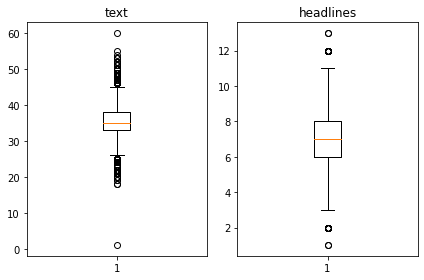

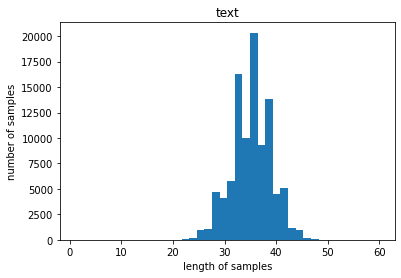

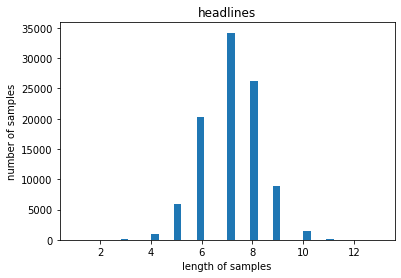

In [98]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [99]:
text_max_len = 45
summary_max_len = 9

In [220]:
data =  data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data =  data[data['headlines'].apply(lambda x: len(x.split()) <= text_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


sos, eos 토큰 삽입

In [102]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al salary hike,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al salary hi...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [103]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

데이터 셔플

In [104]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

데이터 나누기

In [105]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19680


In [106]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78721
훈련 레이블의 개수 : 78721
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


정수 인코딩  
tokenizer.word_index에 단어사전이 있음

In [107]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

단어 빈도에 따라 희소단어 제거

In [111]:
threshold = 8
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69627
등장 빈도가 7번 이하인 희귀 단어의 수: 48942
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20685
단어 집합에서 희귀 단어의 비율: 70.2916971864363
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.8624976881836597


In [112]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [113]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3520, 63, 93, 271, 20, 239, 3834, 3978, 651, 277, 1009, 1009, 2363, 105, 111, 1193, 2948, 2614, 20, 79, 277, 2880, 11, 3520, 1193, 7599, 67, 3172, 1881, 2327, 10494, 277, 99, 1, 3663, 1247, 651, 105], [3500, 525, 4589, 40, 268, 577, 2198, 1291, 2549, 525, 1190, 9, 577, 22, 2377, 2549, 3002, 9858, 4589, 289, 460, 302, 9, 1, 18348, 128, 525], [47, 73, 100, 8979, 4342, 5557, 304, 7, 528, 509, 73, 114, 1422, 30, 4480, 479, 835, 17, 210, 1070, 998, 434, 3785, 59, 3, 13, 312, 1190, 528, 5326, 118, 73, 998, 6, 304, 7, 325, 744, 11, 1399, 966]]


In [114]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [120]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29898
등장 빈도가 6번 이하인 희귀 단어의 수: 20501
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9397
단어 집합에서 희귀 단어의 비율: 68.56980400026758
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.671058670721465


In [121]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2684, 105, 3295, 90, 92, 2066, 33], [1, 314, 3685, 1740, 747, 3001, 551, 1091], [1, 6048, 156, 16, 862, 495, 587, 426], [1, 1078, 47, 373, 38, 193], [1, 4161, 67, 7565, 1691, 8065, 1331, 6392]]
target
decoder  [[2684, 105, 3295, 90, 92, 2066, 33, 2], [314, 3685, 1740, 747, 3001, 551, 1091, 2], [6048, 156, 16, 862, 495, 587, 426, 2], [1078, 47, 373, 38, 193, 2], [4161, 67, 7565, 1691, 8065, 1331, 6392, 2]]


빈도수가 낮은 단어 삭제로 인해 문장 전체가 삭제된 경우를 제거

In [122]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 4
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78717
훈련 레이블의 개수 : 78717
테스트 데이터의 개수 : 19680
테스트 레이블의 개수 : 19680


패딩

In [123]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

인코더

In [132]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_outputs)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_outputs)


디코더

In [133]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size,  return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [134]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

어텐션

In [135]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 45, 128)      2560000     input_10[0][0]                   
__________________________________________________________________________________________________
lstm_18 (LSTM)                  [(None, 45, 256), (N 394240      embedding_9[0][0]                
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련

In [136]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 30s 83ms/step - loss: 6.0475 - val_loss: 5.6063
Epoch 2/50
308/308 [==============================] - 24s 79ms/step - loss: 5.4517 - val_loss: 5.2015
Epoch 3/50
308/308 [==============================] - 25s 80ms/step - loss: 5.0991 - val_loss: 4.9411
Epoch 4/50
308/308 [==============================] - 25s 81ms/step - loss: 4.8245 - val_loss: 4.7428
Epoch 5/50
308/308 [==============================] - 25s 81ms/step - loss: 4.5958 - val_loss: 4.5900
Epoch 6/50
308/308 [==============================] - 25s 82ms/step - loss: 4.4064 - val_loss: 4.4867
Epoch 7/50
308/308 [==============================] - 25s 82ms/step - loss: 4.2459 - val_loss: 4.3867
Epoch 8/50
308/308 [==============================] - 25s 82ms/step - loss: 4.1051 - val_loss: 4.3206
Epoch 9/50
308/308 [==============================] - 25s 82ms/step - loss: 3.9818 - val_loss: 4.2590
Epoch 10/50
308/308 [==============================] - 25s 83ms/step - loss: 3.867

### 시각화

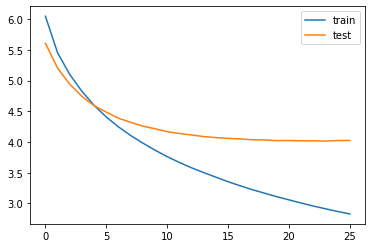

In [138]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델

In [147]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [148]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [149]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [150]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [151]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i not in (0, 1)):
            temp = temp + tar_index_to_word[i]+' '
    return temp


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)


In [160]:
for i in range(10):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : spectrum scam cag claimed caused lakh crore loss national exchequer involved sun tv maran brothers executives reliance including president surendra senior vice president hari nair swan telecom promoters vinod goenka shahid usman unitech managing director sanjay chandra also named accused 
실제 요약 : named scam 
예측 요약 :  cbi seizes crore worth crore scam


원문 : nsg commandos embarked kilometre ride across nation royal enfield classic black motorcycles driving awareness fight back terrorism ride covered many major cities including nsg bases gandhinagar mumbai chennai hyderabad kolkata concluding manesar base unit rd day 
실제 요약 : commandos take km ride royal enfield drive awareness 
예측 요약 :  bullet train launched india


원문 : uk five nations referred europe highest court failing tackle illegal levels air pollution uk france germany hungary italy romania given final warning european commission january deaths across europe due toxic air year 
실제 요약 : uk taken europe highest court air poll

## Step 5. Summa을 이용해서 추출적 요약해보기


추상적 요약을 하던 데이터는 문장수가 적어서 그런지 요약을 하지 못하였음

In [153]:
from summa.summarizer import summarize

In [158]:
seq2text(encoder_input_test[0])

'spectrum scam cag claimed caused lakh crore loss national exchequer involved sun tv maran brothers executives reliance including president surendra senior vice president hari nair swan telecom promoters vinod goenka shahid usman unitech managing director sanjay chandra also named accused '

In [187]:
for i in range(len(encoder_input_test)):
#     print("원문 :", seq2text(encoder_input_test[i]))
#     print("실제 요약 :", seq2summary(decoder_input_test[i]))
    if summarize(seq2text(encoder_input_test[i])):                
        print(f"{i} 예측 요약 :", summarize(seq2text(encoder_input_test[i])))

LMS와 동일하게 진행

장문의 데이터의 경우 잘 요약을 하고 있음

In [168]:
import requests

In [169]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [171]:
summarize(text, ratio=0.005)

'Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.\nTrinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.'

## 마무리 및 회고

**추상적 요약**의 경우 매개변수가 너무 많아 훈련이 오래 걸리긴 했어도 이렇게 간단한 모델로 생각보다 괜찮은 성능이 나온거 같았다. 
모델 학습 시간이 오래 걸려 다양하게 구조변경을 해보지는 못하였던 것이 조금 아쉬움으로 남는다. 이번 모델은 seq2seq에 어텐션 디코더를 이어붙은 모델이었는데, 완전히 트랜스포머로 구성하면 어떨지 궁금하였다. 

추상적 요약을 하던 기사자료를 **추출적 요약**의 방식으로 처리할 수는 없었다. 
기사의 내용이 너무 적은 것으로 파악되며, LMS상에서 제공한 데이터의 요약으로 비교를 하였다. 
훨씬 문법적으로 깔끔하고, 중복단어가 나오지도 않았다. 
원문 전체를 읽지는 않아서 요약이 잘 되었는지는 모르겠지만, 
요약문을 보았을 때는 잘 나온 것 같았다.   

추상적 요약은 잘 나온 적이 있지만, 문법적으로 훨씬 불안적하고 뜬금없는 단어를 사용하기도 하였다. 